# ML Project

Creating a supervised Machine Learning model to predict whether a patient has heartdisease or not

Data retrieved from Kaggle: https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction (2022-12-7)

- Age: age of the patient 
    - [years]
- Sex: sex of the patient 
    - [M: Male, F: Female]
- ChestPainType: chest pain type 
    - [TA: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic]
- RestingBP: resting blood pressure 
    - [mm Hg]
- Cholesterol: serum cholesterol 
    - [mm/dl]
- FastingBS: fasting blood sugar 
    - [1: if FastingBS > 120 mg/dl, 0: otherwise]
- RestingECG: resting electrocardiogram results 
    - [Normal: Normal, ST: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), LVH: showing probable or definite left ventricular hypertrophy by Estes' criteria]
- MaxHR: maximum heart rate achieved 
    - [Numeric value between 60 and 202]
- ExerciseAngina: exercise-induced angina 
    - [Y: Yes, N: No]
- Oldpeak: oldpeak = ST 
    - [Numeric value measured in depression]
- ST_Slope: the slope of the peak exercise ST segment 
    - [Up: upsloping, Flat: flat, Down: downsloping]
- HeartDisease: output class 
    - [1: heart disease, 0: Normal]
    
Since I am investigating heart disease in this project, I have decided to go for maximizing **recall**. This is because of the fact that I regard a false negative worse than a false positive.

In [426]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline

from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler
from sklearn.compose import make_column_selector, make_column_transformer

from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_is_fitted
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

## Data Cleaning

In [371]:
df = pd.read_csv("heart.csv")

In [372]:
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [373]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [489]:
x(['Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol', 'FastingBS',
       'RestingECG', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ST_Slope',
       'HeartDisease', 'grouped_ChestPainType', 'grouped_ST_Slope'],

Index(['Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol', 'FastingBS',
       'RestingECG', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ST_Slope',
       'HeartDisease', 'grouped_ChestPainType', 'grouped_ST_Slope'],
      dtype='object')

### Numerical Columns

In [374]:
df.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


As we can see in the table above, some of the variables have 0-values that do not make sense (such as Resting Blood Pressure). Since we cannot say for sure that these are wrong, and we don't want to remove the whole row, we will apply the RobustScaler to RestingBP.

In [375]:
df.loc[df["RestingBP"] == 0]

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
449,55,M,NAP,0,0,0,Normal,155,N,1.5,Flat,1


In [376]:
df.corr()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
Age,1.000000,0.254399,-0.095282,0.198039,-0.382045,0.258612,0.282039
RestingBP,0.254399,1.000000,0.100893,0.070193,-0.112135,0.164803,0.107589
Cholesterol,-0.095282,0.100893,1.000000,-0.260974,0.235792,0.050148,-0.232741
FastingBS,0.198039,0.070193,-0.260974,1.000000,-0.131438,0.052698,0.267291
MaxHR,-0.382045,-0.112135,0.235792,-0.131438,1.000000,-0.160691,-0.400421
Oldpeak,0.258612,0.164803,0.050148,0.052698,-0.160691,1.000000,0.403951
HeartDisease,0.282039,0.107589,-0.232741,0.267291,-0.400421,0.403951,1.000000


- RestingBP, Age: Drop, low correlation with HeartDisease and or/multicollinearity
- Cholesterol, FastingBS: Also consider dropping
- MaxHR, Oldpeak: Keep

Kind of high correlation between Age and MaxHR, might cause multicollinearity. Only Keep MaxHR in model (higher corr with heartdisease)

### Categorical Columns

In [377]:
df.describe(include = "O")

,Sex,ChestPainType,RestingECG,ExerciseAngina,ST_Slope
count,918,918,918,918,918
unique,2,4,3,2,3
top,M,ASY,Normal,N,Flat
freq,725,496,552,547,460


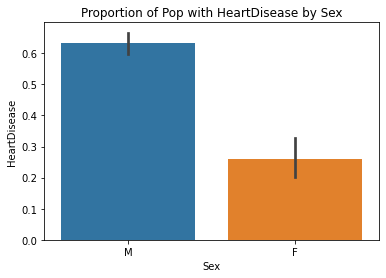

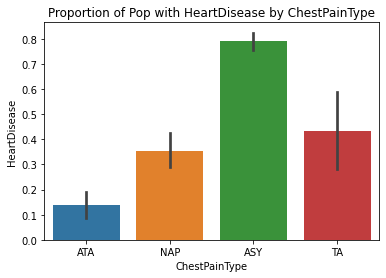

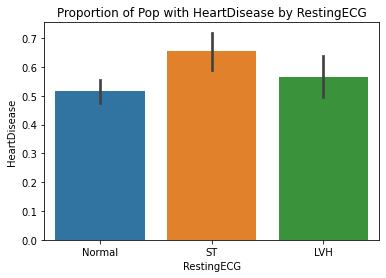

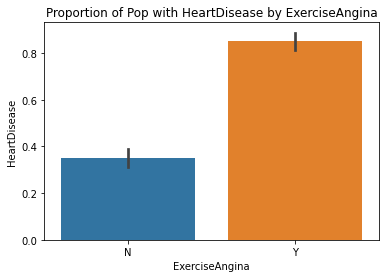

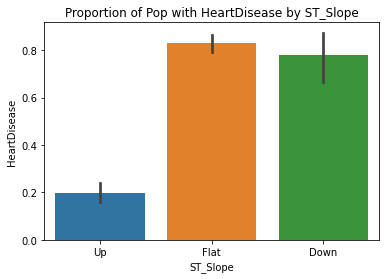

In [378]:
plt.figure()
for col in df.describe(include = "O").columns:
    sns.barplot(data = df, x = col, y = "HeartDisease")
    plt.title(f"Proportion of Pop with HeartDisease by {col}")
    plt.show()

- Sex: Keep, significant difference
- ChestPainType, investigate further - Reasonable to group NAP and TA?
- Resting EGC: Drop
- ExerciseAngina: Keep
- ST_Slope: Investigate further - Reasonable to group Flat and Down?

In [379]:
for i in df.drop("ChestPainType", axis = 1).describe(include = "O").columns:
    print(df.groupby("ChestPainType")[i].value_counts(normalize = True).loc[["NAP", "TA"]])    
    print('\n')

ChestPainType  Sex
NAP            M      0.738916
               F      0.261084
TA             M      0.782609
               F      0.217391
Name: Sex, dtype: float64


ChestPainType  RestingECG
NAP            Normal        0.605911
               LVH           0.231527
               ST            0.162562
TA             Normal        0.478261
               LVH           0.347826
               ST            0.173913
Name: RestingECG, dtype: float64


ChestPainType  ExerciseAngina
NAP            N                 0.748768
               Y                 0.251232
TA             N                 0.869565
               Y                 0.130435
Name: ExerciseAngina, dtype: float64


ChestPainType  ST_Slope
NAP            Up          0.517241
               Flat        0.433498
               Down        0.049261
TA             Flat        0.478261
               Up          0.434783
               Down        0.086957
Name: ST_Slope, dtype: float64




In [380]:
for i in df.describe().columns:
    print(f"Average {i}:")
    print(df.groupby("ChestPainType")[i].mean().loc[["NAP", "TA"]])    
    print('\n')

Average Age:
ChestPainType
NAP    53.310345
TA     54.826087
Name: Age, dtype: float64


Average RestingBP:
ChestPainType
NAP    130.960591
TA     136.413043
Name: RestingBP, dtype: float64


Average Cholesterol:
ChestPainType
NAP    197.438424
TA     207.065217
Name: Cholesterol, dtype: float64


Average FastingBS:
ChestPainType
NAP    0.201970
TA     0.282609
Name: FastingBS, dtype: float64


Average MaxHR:
ChestPainType
NAP    143.236453
TA     147.891304
Name: MaxHR, dtype: float64


Average Oldpeak:
ChestPainType
NAP    0.674877
TA     1.036957
Name: Oldpeak, dtype: float64


Average HeartDisease:
ChestPainType
NAP    0.354680
TA     0.434783
Name: HeartDisease, dtype: float64




In the output above, you can see the relative frequency of the inner value, within each group of the outer values (i.e. ChestPainType). From the output above, we cannot distinguish any significant differences between group NAP and TA in terms of other variables. You could argue that it is a somewhat big differences in terms of cholesterol and OldPeak, but we can account for the differences by keeping them in the model. I therefore deem that it is reasonable to group them in the ChestPainType group, leaving us with the following unique values: ["ATA", "NAP/TA", "ASY"]

In [381]:
for i in df.drop("ST_Slope", axis = 1).describe(include = "O").columns:
    print(df.groupby("ST_Slope")[i].value_counts(normalize = True).loc[["Flat", "Down"]])
    print('\n')

ST_Slope  Sex
Flat      M      0.836957
          F      0.163043
Down      M      0.888889
          F      0.111111
Name: Sex, dtype: float64


ST_Slope  ChestPainType
Flat      ASY              0.691304
          NAP              0.191304
          ATA              0.069565
          TA               0.047826
Down      ASY              0.730159
          NAP              0.158730
          TA               0.063492
          ATA              0.047619
Name: ChestPainType, dtype: float64


ST_Slope  RestingECG
Flat      Normal        0.578261
          LVH           0.210870
          ST            0.210870
Down      Normal        0.492063
          LVH           0.269841
          ST            0.238095
Name: RestingECG, dtype: float64


ST_Slope  ExerciseAngina
Flat      Y                 0.591304
          N                 0.408696
Down      Y                 0.650794
          N                 0.349206
Name: ExerciseAngina, dtype: float64




In [382]:
for i in df.describe().columns:
    print(f"Average {i}:")
    print(df.groupby("ST_Slope")[i].mean().loc[["Flat", "Down"]])
    print('\n')

Average Age:
ST_Slope
Flat    55.256522
Down    58.317460
Name: Age, dtype: float64


Average RestingBP:
ST_Slope
Flat    134.228261
Down    131.857143
Name: RestingBP, dtype: float64


Average Cholesterol:
ST_Slope
Flat    193.241304
Down    165.222222
Name: Cholesterol, dtype: float64


Average FastingBS:
ST_Slope
Flat    0.278261
Down    0.396825
Name: FastingBS, dtype: float64


Average MaxHR:
ST_Slope
Flat    128.110870
Down    129.936508
Name: MaxHR, dtype: float64


Average Oldpeak:
ST_Slope
Flat    1.188696
Down    2.152381
Name: Oldpeak, dtype: float64


Average HeartDisease:
ST_Slope
Flat    0.828261
Down    0.777778
Name: HeartDisease, dtype: float64




In the output above, you can see the relative frequency of the inner value, within each group of the subset of the outer values (i.e. ST_Slope). We have used a subset of the variable here, since we are interested in investigating whether or not it is reasonable to group these variables (we want to do this based on the result from the barplots). From the output above, we cannot distinguish any signficant differences between group Flat and Down in terms of other variables. You could argue that it is a somewhat big differences in terms of cholesterol and OldPeak, but we can account for the differences by keeping them in the model. I therefore deem that it is reasonable to group them in the ST_Slope group, leaving us with the following unique values: ["Up", "Not Up"]

In [383]:
df["grouped_ChestPainType"] = df["ChestPainType"].apply(lambda x: "TA/NAP" if x in ["NAP", "TA"] else x)

In [384]:
df["grouped_ST_Slope"] = df["ST_Slope"].apply(lambda x: "Not_Up" if x in ["Flat", "Down"] else x)

In [385]:
df

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease,grouped_ChestPainType,grouped_ST_Slope
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0,ATA,Up
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1,TA/NAP,Not_Up
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0,ATA,Up
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1,ASY,Not_Up
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0,TA/NAP,Up
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,M,TA,110,264,0,Normal,132,N,1.2,Flat,1,TA/NAP,Not_Up
914,68,M,ASY,144,193,1,Normal,141,N,3.4,Flat,1,ASY,Not_Up
915,57,M,ASY,130,131,0,Normal,115,Y,1.2,Flat,1,ASY,Not_Up
916,57,F,ATA,130,236,0,LVH,174,N,0.0,Flat,1,ATA,Not_Up


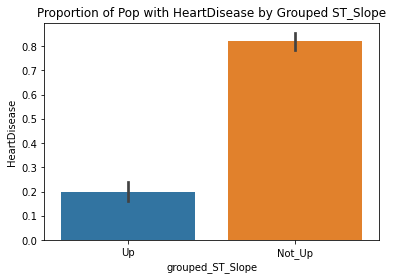

In [491]:
plt.figure()
sns.barplot(data = df, x = "grouped_ST_Slope", y = "HeartDisease")
plt.title("Proportion of Pop with HeartDisease by Grouped ST_Slope")
plt.show()

### Summary:
Variables of interest:
- Numerical:
    - MaxHR, Oldpeak, Cholesterol: Keep
    - FastingBS: Consider Keeping
- Categorical:
    - Sex, ExerciseAngina: Keep, significant difference
    - ChestPainType: Keep with group of NAP and TA
    - ST_Slope: Keep with  group of Flat and Down (= not_up)


# Testing Models

In this section I am going to try out a bunch of different models with 2 different set of features, first a subset of features based on the analysis above, and secondly all features together. Using these features I am going to try out different models to see which one yields the highest recall score. After choosing a model (or more if they are very similar), we will proceed with hyperparameter tuning.

## Baseline

In [472]:
baseline = df["HeartDisease"].value_counts(normalize = True).iloc[0]

In [475]:
print(f"Baseline to beat is about {round(baseline,4) * 100}, since about 55% of the population in the data set have a heart disease")


Baseline to beat is about 55.34, since about 55% of the population in the data set have a heart disease


## Test Models with Subset of Variables

Trying different models with a subset of variables, maximizing for Recall

### X and y

In [388]:
df.columns

Index(['Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol', 'FastingBS',
       'RestingECG', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ST_Slope',
       'HeartDisease', 'grouped_ChestPainType', 'grouped_ST_Slope'],
      dtype='object')

In [389]:
X = df.drop(columns = ["HeartDisease", "Age", "RestingBP", "RestingECG", "ChestPainType", "ST_Slope"])
y = df["HeartDisease"]

### Train/Test-Split

In [390]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 69)

### Create Custom Preprocessor

try to make it into numpy array

In [300]:
# Create my own preprocessing functions, to group values inside column

# The ColumnsSelector class inherits from the sklearn.base classes 
# (BaseEstimator, TransformerMixin). This makes it compatible with 
# scikit-learn’s Pipelines
class GroupColumns(BaseEstimator, TransformerMixin):
    # initializer 
    def __init__(self, columns, values, group_names):
        # save the inputed variables internally in the class
        self.columns = columns
        self.values = values
        self.group_names = group_names
    
    # fits the model, not neccessary when we do not want to calculate anything based on the X input (e.g. mean)
    def fit(self, X, y = None):
        return self
    
    #actual transformation to be done, in this case group values in columns and call new values group_name
    def transform(self, X, y = None):
        # return the dataframe with the specified features
        for col in self.columns:
            X[col] = X[col].apply(lambda x: self.group_names[col] if x in self.values[col] else x)
        return np.array[X]

In [151]:
class MyStandardScaler(BaseEstimator, TransformerMixin): 
    def __init__(self):
        return None
    
    def fit(self, X, y = None):
        print(type(X))
        # the type of X might be a DataFrame or a NumPy array
        # depending on the previous transformer object that 
        # you use in the pipeline
        self.means = np.mean(X, axis=0)    # calculate the mean
        self.stds = np.std(X, axis=0)      # calculate the 
                                           # standard deviation
        return self
    def transform(self, X, y = None):
        return (X - self.means) / self.stds

In [305]:
# preprocessing for numerical columns
num_cols = X.select_dtypes("number").columns

num_trans = make_pipeline(SimpleImputer(strategy = "median"),
                          GroupColumns(columns = ["ChestPainType", "ST_Slop"], values = {"ChestPainType" : ["NAP", "TA"], "ST_Slope" : ["Flat", "Down"]}, group_names = {"ChestPainType" : "NAP/TA", "ST_Slope" : "Not_Up"}),
                          RobustScaler())

#preprocessing of categorical columns
cat_cols = X.describe(include = "O").columns

cat_trans = make_pipeline(SimpleImputer(strategy = "constant", fill_value = "missing"),
                          OneHotEncoder(drop = "first"))

preprocessor = make_column_transformer((num_trans, num_cols), (cat_trans, cat_cols))

In [306]:
pipe = make_pipeline(preprocessor, SVC())

pipe.best_score_

AttributeError: 'Pipeline' object has no attribute 'best_score_'

### Preprocessor

In [391]:
X_train.describe().columns

Index(['Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak'], dtype='object')

In [392]:
# preprocessing for numerical columns
num_cols = X.select_dtypes("number").columns

num_trans = make_pipeline(SimpleImputer(strategy = "median"), RobustScaler())

#preprocessing of categorical columns
cat_cols = X.describe(include = "O").columns

cat_trans = make_pipeline(SimpleImputer(strategy = "constant", fill_value = "missing"),
                          OneHotEncoder(drop = "first"))

preprocessor = make_column_transformer((num_trans, num_cols), (cat_trans, cat_cols))

### Evaluate Models

In [393]:
classifiers = [RandomForestClassifier(), 
                SVC(), 
                LogisticRegression(),
                DecisionTreeClassifier(),
                KNeighborsClassifier(),
                LinearDiscriminantAnalysis(),
                GaussianNB()]

for clf in classifiers:
    pipe = make_pipeline(preprocessor, clf)
    grid = GridSearchCV(estimator = pipe, 
                       cv = 10,
                       scoring = "recall",
                       param_grid = {},
                       n_jobs = -1)
    grid.fit(X_train, y_train)
    score = grid.best_score_
    print(f"{clf} scored: {score}\n")
    

RandomForestClassifier() scored: 0.873231707317073

SVC() scored: 0.9154878048780489

LogisticRegression() scored: 0.8955487804878048

DecisionTreeClassifier() scored: 0.8186585365853658

KNeighborsClassifier() scored: 0.8881707317073172

LinearDiscriminantAnalysis() scored: 0.890548780487805

GaussianNB() scored: 0.8534146341463416



## Test Models with All Variables

Trying different models with all, maximizing for Recall

In [394]:
df.columns

Index(['Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol', 'FastingBS',
       'RestingECG', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ST_Slope',
       'HeartDisease', 'grouped_ChestPainType', 'grouped_ST_Slope'],
      dtype='object')

### X & y

In [395]:
X = df.drop(columns = ['HeartDisease', 'grouped_ChestPainType', 'grouped_ST_Slope'])
y = df["HeartDisease"]

### Train/Test-Split

In [396]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 69)

### Preprocessor

In [397]:
# preprocessing for numerical columns
num_cols = X.select_dtypes("number").columns

num_trans = make_pipeline(SimpleImputer(strategy = "median"), RobustScaler())

#preprocessing of categorical columns
cat_cols = X.describe(include = "O").columns

cat_trans = make_pipeline(SimpleImputer(strategy = "constant", fill_value = "missing"),
                          OneHotEncoder(drop = "first"))

preprocessor = make_column_transformer((num_trans, num_cols), (cat_trans, cat_cols))

### Evaluate Models

In [398]:
classifiers = [RandomForestClassifier(), 
                SVC(), 
                LogisticRegression(),
                DecisionTreeClassifier(),
                KNeighborsClassifier(),
                LinearDiscriminantAnalysis(),
                GaussianNB()]

for clf in classifiers:
    pipe = make_pipeline(preprocessor, clf)
    grid = GridSearchCV(estimator = pipe, 
                       cv = 10,
                       scoring = "recall",
                       param_grid = {},
                       n_jobs = -1)
    grid.fit(X_train, y_train)
    score = grid.best_score_
    print(f"{clf} scored: {score}\n")
    

RandomForestClassifier() scored: 0.8857317073170732

SVC() scored: 0.915609756097561

LogisticRegression() scored: 0.8979878048780489

DecisionTreeClassifier() scored: 0.788658536585366

KNeighborsClassifier() scored: 0.8956707317073169

LinearDiscriminantAnalysis() scored: 0.890548780487805

GaussianNB() scored: 0.8731707317073172



## Summary Comparison:
The recall score does not differ very much between the model with reduced features and all features (not more than 2 % units) and I therefore choose to go with the reduced model. Furthermore, the SVC yielded the highest score butI've chosen to include close contenders (RandomForest, LogisticRegression and KNeighbors) aswell to see if hyperparameter tuning makes a difference.

## Hyperparameter Tuning

In [478]:
X = df.drop(columns = ["HeartDisease", "Age", "RestingBP", "RestingECG", "ChestPainType", "ST_Slope"])
y = df["HeartDisease"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [400]:
X_train.columns

Index(['Sex', 'Cholesterol', 'FastingBS', 'MaxHR', 'ExerciseAngina', 'Oldpeak',
       'grouped_ChestPainType', 'grouped_ST_Slope'],
      dtype='object')

In [404]:
# preprocessing for numerical columns
num_cols = X.select_dtypes("number").columns

num_trans = make_pipeline(SimpleImputer(strategy = "median"), RobustScaler())

#preprocessing of categorical columns
cat_cols = X.describe(include = "O").columns

cat_trans = make_pipeline(SimpleImputer(strategy = "constant", fill_value = "missing"),
                          OneHotEncoder(drop = "first"))

preprocessor = make_column_transformer((num_trans, num_cols), (cat_trans, cat_cols))

### `SVC()`

In [405]:
# defining parameter range
param_grid_svc = {'svc__C': [0.1, 1, 10, 100], 
              'svc__gamma': [1, 0.1, 0.01]} 
pipe_svc = make_pipeline(preprocessor, SVC())

grid_svc = GridSearchCV(estimator = pipe_svc, 
                    param_grid = param_grid_svc, 
                    n_jobs = -1, 
                    cv = 10,
                    scoring = "recall"
                    )
  
# fitting the model for grid search
grid_svc.fit(X_train, y_train)

print("Best Score:", grid_svc.best_score_)
print("Best Params:", grid_svc.best_params_)

Best Score: 0.9388414634146341
Best Params: {'svc__C': 0.1, 'svc__gamma': 1}


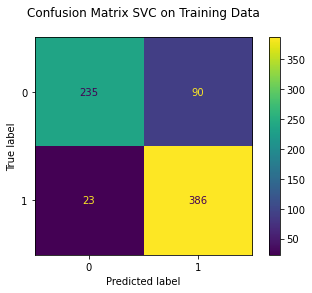

Recall: 0.9437652811735942
Precision: 0.8109243697478992
Accuracy: 0.8460490463215259
Average: 0.8669128990810063
F1_Score: 0.8723163841807909


In [443]:
cm = confusion_matrix(y_train, grid_svc.predict(X_train))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=grid_svc.classes_)

disp.plot()
plt.title("Confusion Matrix SVC on Training Data\n")
plt.show()
print(f"Recall: {recall_score(y_train, grid_svc.predict(X_train))}")
print(f"Precision: {precision_score(y_train, grid_svc.predict(X_train))}")
print(f"Accuracy: {accuracy_score(y_train, grid_svc.predict(X_train))}")
print(f"Average: {(recall_score(y_train, grid_svc.predict(X_train)) + precision_score(y_train, grid_svc.predict(X_train)) + accuracy_score(y_train, grid_svc.predict(X_train))) / 3}")
print(f"F1_Score: {f1_score(y_train, grid_svc.predict(X_train))}")



### `RandomForestClassifier()`

In [407]:
# defining parameter range
param_grid_rf = {"randomforestclassifier__max_depth" : [None, 5, 10, 25, 50],
                "randomforestclassifier__min_samples_leaf" : [1, 2, 4, 8],
                "randomforestclassifier__n_estimators" : [50, 100, 200],
                'randomforestclassifier__min_samples_split': [2, 5, 10, 20]}

pipe_rf = make_pipeline(preprocessor, RandomForestClassifier())

grid_rf = GridSearchCV(estimator = pipe_rf, 
                    param_grid = param_grid_rf, 
                    n_jobs = -1, 
                    cv = 10,
                    scoring = "recall"
                    )
  
# fitting the model for grid search
grid_rf.fit(X_train, y_train)

print("Best Score:", grid_rf.best_score_)
print("Best Params:", grid_rf.best_params_)

Best Score: 0.9144512195121951
Best Params: {'randomforestclassifier__max_depth': 25, 'randomforestclassifier__min_samples_leaf': 8, 'randomforestclassifier__min_samples_split': 20, 'randomforestclassifier__n_estimators': 100}


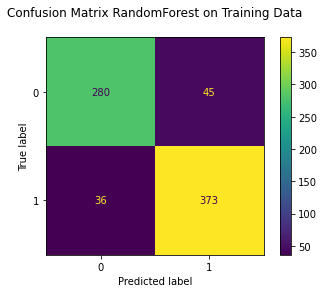

Recall: 0.9119804400977995
Precision: 0.8923444976076556
Accuracy: 0.8896457765667575
Average: 0.8979902380907375
F1_Score: 0.9020556227327691


In [442]:
cm = metrics.confusion_matrix(y_train, grid_rf.predict(X_train))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=grid_rf.classes_)

disp.plot()
plt.title("Confusion Matrix RandomForest on Training Data\n")
plt.show()
print(f"Recall: {recall_score(y_train, grid_rf.predict(X_train))}")
print(f"Precision: {precision_score(y_train, grid_rf.predict(X_train))}")
print(f"Accuracy: {accuracy_score(y_train, grid_rf.predict(X_train))}")
print(f"Average: {(recall_score(y_train, grid_rf.predict(X_train)) + precision_score(y_train, grid_rf.predict(X_train)) + accuracy_score(y_train, grid_rf.predict(X_train))) / 3}")
print(f"F1_Score: {f1_score(y_train, grid_rf.predict(X_train))}")



### `KNeighborsClassifier()`

In [410]:
# defining parameter range
param_grid_knn = {"kneighborsclassifier__n_neighbors" : [1, 3, 5, 10, 25, 50],
                "kneighborsclassifier__leaf_size" : [1, 5, 10, 30, 50],
                "kneighborsclassifier__p" : [1,2]}

pipe_knn = make_pipeline(preprocessor, KNeighborsClassifier())

grid_knn = GridSearchCV(estimator = pipe_knn, 
                    param_grid = param_grid_knn, 
                    n_jobs = -1, 
                    cv = 10,
                    scoring = "recall"
                    )
  
# fitting the model for grid search
grid_knn.fit(X_train, y_train)

print("Best Score:", grid_knn.best_score_)
print("Best Params:", grid_knn.best_params_)

Best Score: 0.8973170731707316
Best Params: {'kneighborsclassifier__leaf_size': 1, 'kneighborsclassifier__n_neighbors': 25, 'kneighborsclassifier__p': 1}


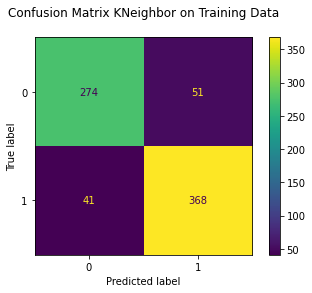

Recall: 0.8997555012224939
Precision: 0.8782816229116945
Accuracy: 0.8746594005449592
Average: 0.8842321748930493
F1_Score: 0.888888888888889


In [441]:
cm = metrics.confusion_matrix(y_train, grid_knn.predict(X_train))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=grid_knn.classes_)

disp.plot()
plt.title("Confusion Matrix KNeighbor on Training Data\n")
plt.show()
print(f"Recall: {recall_score(y_train, grid_knn.predict(X_train))}")
print(f"Precision: {precision_score(y_train, grid_knn.predict(X_train))}")
print(f"Accuracy: {accuracy_score(y_train, grid_knn.predict(X_train))}")
print(f"Average: {(recall_score(y_train, grid_knn.predict(X_train)) + precision_score(y_train, grid_knn.predict(X_train)) + accuracy_score(y_train, grid_knn.predict(X_train))) / 3}")
print(f"F1_Score: {f1_score(y_train, grid_knn.predict(X_train))}")



In [424]:
# defining parameter range
param_grid_logreg = {"logisticregression__C" : [0.001, 0.01, 0.1, 1, 5, 10, 50]}

pipe_logreg = make_pipeline(preprocessor, LogisticRegression())

grid_logreg = GridSearchCV(estimator = pipe_logreg, 
                    param_grid = param_grid_logreg, 
                    n_jobs = -1, 
                    cv = 10,
                    scoring = "recall"
                    )
  
# fitting the model for grid search
grid_logreg.fit(X_train, y_train)

print("Best Score:", grid_logreg.best_score_)
print("Best Params:", grid_logreg.best_params_)

Best Score: 0.9779268292682927
Best Params: {'logisticregression__C': 0.001}


### `LogisticRegression()`

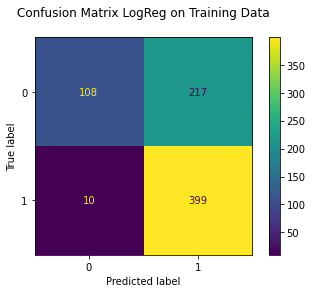

Recall: 0.9755501222493888
Precision: 0.6477272727272727
Accuracy: 0.6907356948228883
Average: 0.7713376965998499
F1_Score: 0.7785365853658537


In [440]:
cm = metrics.confusion_matrix(y_train, grid_logreg.predict(X_train))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=grid_knn.classes_)

disp.plot()
plt.title("Confusion Matrix LogReg on Training Data\n")
plt.show()
print(f"Recall: {recall_score(y_train, grid_logreg.predict(X_train))}")
print(f"Precision: {precision_score(y_train, grid_logreg.predict(X_train))}")
print(f"Accuracy: {accuracy_score(y_train, grid_logreg.predict(X_train))}")
print(f"Average: {(recall_score(y_train, grid_logreg.predict(X_train)) + precision_score(y_train, grid_logreg.predict(X_train)) + accuracy_score(y_train, grid_logreg.predict(X_train))) / 3}")
print(f"F1_Score: {f1_score(y_train, grid_logreg.predict(X_train))}")




## Decision
Based on the data from the different models when hyperparameter tuning them, we can conclude the the logistic regression yields the highest recall score, however, looking at the confusion matrix and the other scores, we can see that it is bad in terms of precision. Even though we optimized the model for recall, since we want to minimize the number of FN, that does not mean that precision is not important. A FP, i.e. telling a patient that they have a heart disease even though they do not, can result in high costs for the hospital if they continue with treatment for the patient. Also, some treatment might me harmful for a patient that is in fact healthy. Therefore, I've concluded to go ahead with the SVC model that yields a high recall (although not AS high as logreg) but also yields a relatively high precision score.

## Refitting Model on All training Data

- SVC()
- {'svc__C': 0.1, 'svc__gamma': 1}

In [444]:
pipe_final = make_pipeline(preprocessor, SVC(C = 0.1, gamma = 1))

In [445]:
pipe_final.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('robustscaler',
                                                                   RobustScaler())]),
                                                  Index(['Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak'], dtype='object')),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(drop='first'))]),
                                                  Index(['Sex', 'ExerciseAngina', 'grouped_ChestPainType', 'grouped_ST_Slope'], dtype='object'))])),
                ('svc', SVC(C=0.1, gamma=1))])

## Evaluation on Test Data

In [479]:
y_test_pred = pipe_final.predict(X_test)

In [480]:
print(f"Recall Score on Test Data: {recall_score(y_test, y_test_pred)}")
print(f"Precision Score on Test Data: {precision_score(y_test, y_test_pred)}")
print(f"Accuracy Score on Test Data: {accuracy_score(y_test, y_test_pred)}")
print(f"Average Score on Test Data: {(recall_score(y_test, y_test_pred) + precision_score(y_test, y_test_pred) + accuracy_score(y_test, y_test_pred)) / 3}")
print(f"F1_Score Score on Test Data: {f1_score(y_test, y_test_pred)}")


Recall Score on Test Data: 0.96
Precision Score on Test Data: 0.7741935483870968
Accuracy Score on Test Data: 0.8260869565217391
Average Score on Test Data: 0.8534268349696119
F1_Score Score on Test Data: 0.8571428571428571


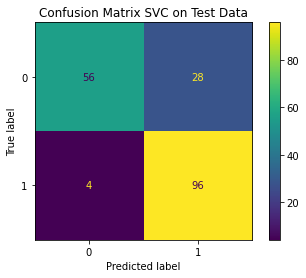

In [481]:
cm = metrics.confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=pipe_final.classes_)

disp.plot()
plt.title("Confusion Matrix SVC on Test Data")
plt.show()

## Refit Model on All Data

In [482]:
X

,Sex,Cholesterol,FastingBS,MaxHR,ExerciseAngina,Oldpeak,grouped_ChestPainType,grouped_ST_Slope
0,M,289,0,172,N,0.0,ATA,Up
1,F,180,0,156,N,1.0,TA/NAP,Not_Up
2,M,283,0,98,N,0.0,ATA,Up
3,F,214,0,108,Y,1.5,ASY,Not_Up
4,M,195,0,122,N,0.0,TA/NAP,Up
...,...,...,...,...,...,...,...,...
913,M,264,0,132,N,1.2,TA/NAP,Not_Up
914,M,193,1,141,N,3.4,ASY,Not_Up
915,M,131,0,115,Y,1.2,ASY,Not_Up
916,F,236,0,174,N,0.0,ATA,Not_Up


In [483]:
y

0      0
1      1
2      0
3      1
4      0
      ..
913    1
914    1
915    1
916    1
917    0
Name: HeartDisease, Length: 918, dtype: int64

In [484]:
model = pipe_final.fit(X, y)

## Save ML Workflow as Pickle

In [485]:
from joblib import dump

In [486]:
# serialize the model to our harddrive for future use
dump(model, "heart_disease_predicition_model.joblib")

['heart_disease_predicition_model.joblib']

## Evaluate Model against Baseline

In [487]:
baseline

0.5533769063180828

In [488]:
recall_score(y_test, y_test_pred)

0.96

Obviously, our recall score is way above our baseline. However, I would not say that this baseline is a valid number to try to beat, but it was the best I could come up with. Baseline is just the proportion of people in the data set that have heart disease, and that is not really what we are optimizing for. A more reasonable baseline would be to compare against the recall score of actual doctors diagnoses, i.e. how often do doctors wrongly tell patient with heart disease that he or she is healthy. However, since I do not have such data, this is what I had to base my analysis on.